In [8]:
from PIL import Image, ImageDraw
from io import BytesIO
import json
import joblib
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

random.seed(25)

DATA_PATH = '/data4/imagenet/ILSVRC/Data/CLS-LOC/train/'

In [2]:
# Data loader
class ImageNetSolo(Dataset):
    def __init__(self, index, data_path):
        super(ImageNetSolo, self).__init__()
        categories = os.listdir(data_path)
        names = os.listdir(os.path.join(data_path, categories[index]))
        self.category = categories[index]
        self.images = [os.path.join(DATA_PATH, categories[index], name) for name in names]
        self.transform = transforms.Compose([
                            transforms.Resize(260),
                            transforms.CenterCrop(256),
                            transforms.ToTensor(),])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        path = self.images[index]
        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')
            sample = self.transform(sample)
        return sample, index
    
def get_loader(index, batch_size=256):
    dataset = ImageNetSolo(index, DATA_PATH)
    loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)
    return loader, dataset

In [3]:
def get_outputs(model, index):
    # show reconstructed image
    indexes = []
    features = []
    out_paths = []
    model.eval()
    val_loader, val_data = get_loader(index=index, batch_size=32)
    img_paths = val_data.images
    category = val_data.category
    
    with torch.no_grad():
        for images, ids in val_loader:
            images = images.cuda()
            z = model(images)
            indexes.append(ids.view(-1).cpu())
            features.append(z.cpu())
        indexes = torch.cat(indexes, dim=0).numpy()
        features = torch.cat(features, dim=0).numpy()
    
    for idx in list(indexes):
        out_paths.append(img_paths[idx])
    return features, out_paths, category

In [19]:
def get_cluster_label(features, category, out_paths, output_dict, NUM_CLUSTER=6):
    output_dict[category] = {}
    kmeans = KMeans(n_clusters=NUM_CLUSTER).fit(features)
    for path, label in zip(out_paths, list(kmeans.labels_)):
        if label in output_dict[category]:
            output_dict[category][label].append(path)
        else:
            output_dict[category][label] = [path,]
    return output_dict, kmeans.labels_

In [20]:
def displays_image_list(path_dict, print_number=5, num_per_line=15):
    plt.figure(figsize=(num_per_line*2,print_number*2))
    for k in range(print_number):
        lines = print_number
        for j in range(num_per_line):
            idx = k * num_per_line + j
            idx_plot = idx
            img_temp = Image.open(path_dict[k][j]).resize((64,64))
            #Image.fromarray(np.uint8((org_img[intra_label[k][j]])*255))
            ax = plt.subplot(lines, num_per_line, idx_plot+1)##控制plot位置
            plt.imshow(img_temp)

In [21]:
# load moco model
model = torchvision.models.resnet50(pretrained=True).cuda()
model.fc = nn.ReLU()

In [22]:
output_dict = {}
NUM_CLUSTER = 6
index = 1
print('======== Leanring {} category ==========='.format(index))
features, out_paths, category = get_outputs(model, index)
output_dict, att_labels = get_cluster_label(features, category, out_paths, output_dict, NUM_CLUSTER=NUM_CLUSTER)
# save features and image paths

======== Leanring 1 category ===========


In [35]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt_style = 'seaborn-talk'

In [36]:
def do_plot(X_fit, labels, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

In [37]:
tsne2 = TSNE(n_components=2, random_state=0)
tsne_feats = tsne2.fit_transform(features)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

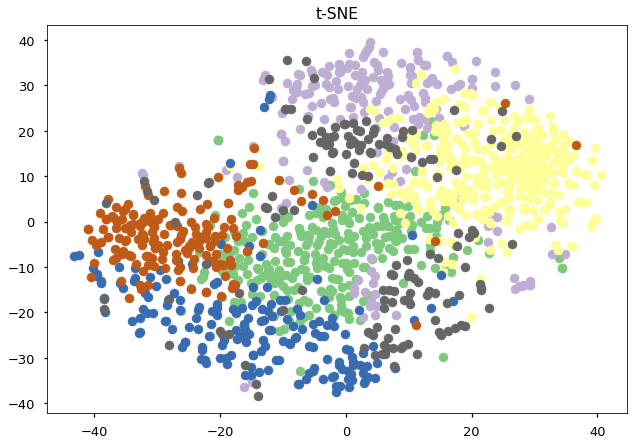

In [38]:
do_plot(tsne_feats, att_labels, 't-SNE')